In [1]:
import nbimporter
from data_loader import load_data
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint


c:\Users\Nouran\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_SIZE = (224, 224)  # ResNet50 default input size
BATCH_SIZE = 64
EPOCHS = 50

In [3]:
train_gen, val_gen, test_gen, _ = load_data(
    train_path="C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/train",
    valid_path="C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/valid",
    test_path="C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/test",
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)


Found 4793 images belonging to 30 classes.
Found 150 images belonging to 30 classes.
Found 150 images belonging to 30 classes.


In [4]:
# Number of classes (from your loaded generators)
NUM_CLASSES = len(train_gen.class_indices)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 30


In [5]:
# Load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [6]:
for layer in base_model.layers[:-100]:  # Freeze fewer layers
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)


In [7]:
# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,654,238 (94.05 MB)

 Trainable params: 23,217,438 (88.57 MB)

 Non-trainable params: 1,436,800 (5.48 MB)

In [10]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [11]:
# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)


C:\Users\Nouran\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 291s 4s/step - accuracy: 0.0850 - loss: 4.0957 - val_accuracy: 0.0533 - val_loss: 3.4655 - learning_rate: 1.0000e-04
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 273s 4s/step - accuracy: 0.2502 - loss: 2.7992 - val_accuracy: 0.3000 - val_loss: 2.6525 - learning_rate: 1.0000e-04
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 364s 5s/step - accuracy: 0.3880 - loss: 2.3031 - val_accuracy: 0.5533 - val_loss: 1.6586 - learning_rate: 1.0000e-04
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 528s 7s/step - accuracy: 0.4692 - loss: 1.9304 - val_accuracy: 0.7200 - val_loss: 0.9669 - learning_rate: 1.0000e-04
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 640s 9s/step - accuracy: 0.5510 - loss: 1.5718 - val_accuracy: 0.7800 - val_loss: 0.7954 - learning_rate: 1.0000e-04
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 603s 8s/step - accuracy: 0.6023 - loss: 1.4254 - val_accuracy: 0.8133 - val_loss: 0.7569 - learning_rate: 1.0000e-04
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 626s 8s/step - accuracy: 0.6496 

In [12]:
# Evaluate
loss, accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9421 - loss: 0.2279
Test Accuracy: 94.67%


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === Step 1: Unfreeze the top layers of the base model ===
# Unfreeze only the last 50 layers for fine-tuning (not all!)
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# === Step 2: Compile the model with a slightly higher learning rate ===
model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Step 3: Callbacks to prevent overfitting and plateauing ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-7)

# === Step 4: Fine-tune the model ===
fine_tune_epochs = 30  # or more, depending on patience
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=fine_tune_epochs,
    callbacks=[early_stop, reduce_lr]
)

# === Step 5: Final evaluation ===
loss_fine, accuracy_fine = model.evaluate(test_gen)
print(f" Final Test Accuracy after fine-tuning: {accuracy_fine * 100:.2f}%")


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.8880 - loss: 0.3850 - val_accuracy: 0.9400 - val_loss: 0.2122 - learning_rate: 5.0000e-06
Epoch 2/30
49/75 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - accuracy: 0.8929 - loss: 0.3604

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


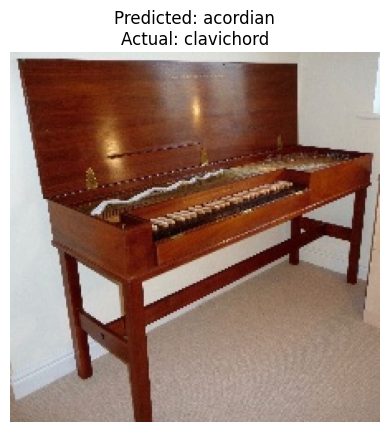

In [ ]:
from tensorflow.keras.preprocessing import image
import random, os

import matplotlib.pyplot as plt

# Pick a random image from the test set

# Get a random class directory
random_class = random.choice(os.listdir(test_directory))
random_class_dir = os.path.join(test_directory, random_class)
# Get a random image file from that class
random_img_file = random.choice(os.listdir(random_class_dir))
random_img_path = os.path.join(random_class_dir, random_img_file)

# Load and preprocess the image
img = image.load_img(random_img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict
preds = model.predict(img_array)
predicted_index = np.argmax(preds, axis=1)[0]
predicted_label = class_names[predicted_index]

# Show the image and prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_label}\nActual: {random_class}")
plt.show()